# Homework 08


## Question 1


In [7]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


#### a)

1) Assign each point to a cluster N at random.
2) Calculate the mean position of each cluster using the previous assignments.
3) Loop through the points - assign each point to the cluster to whose center it is closest.
4) Repeat this process until the centers stop moving around.

#### b)

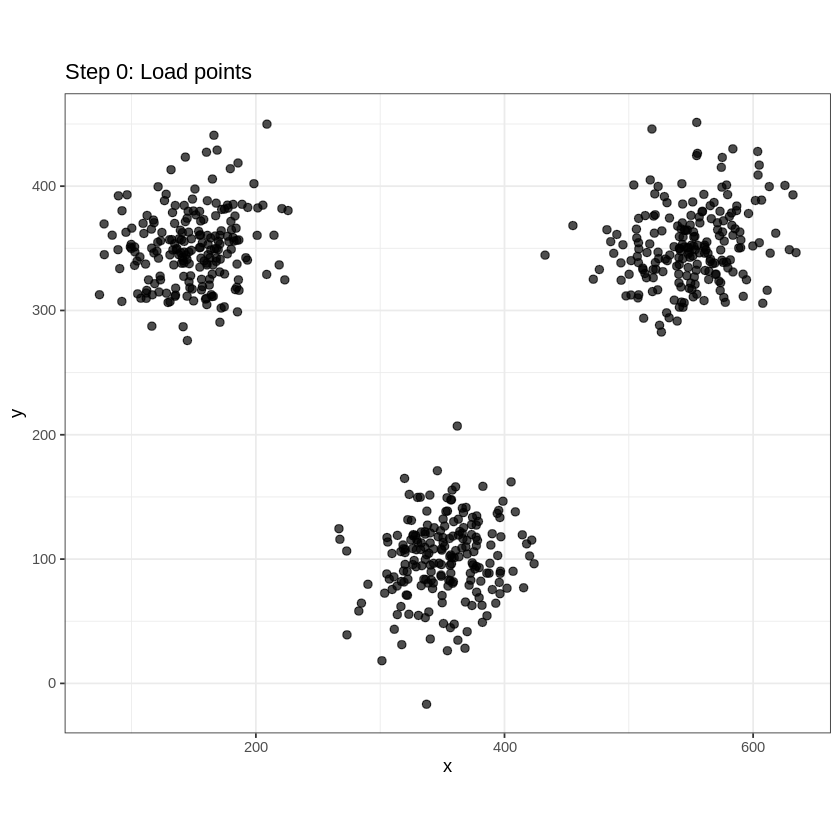

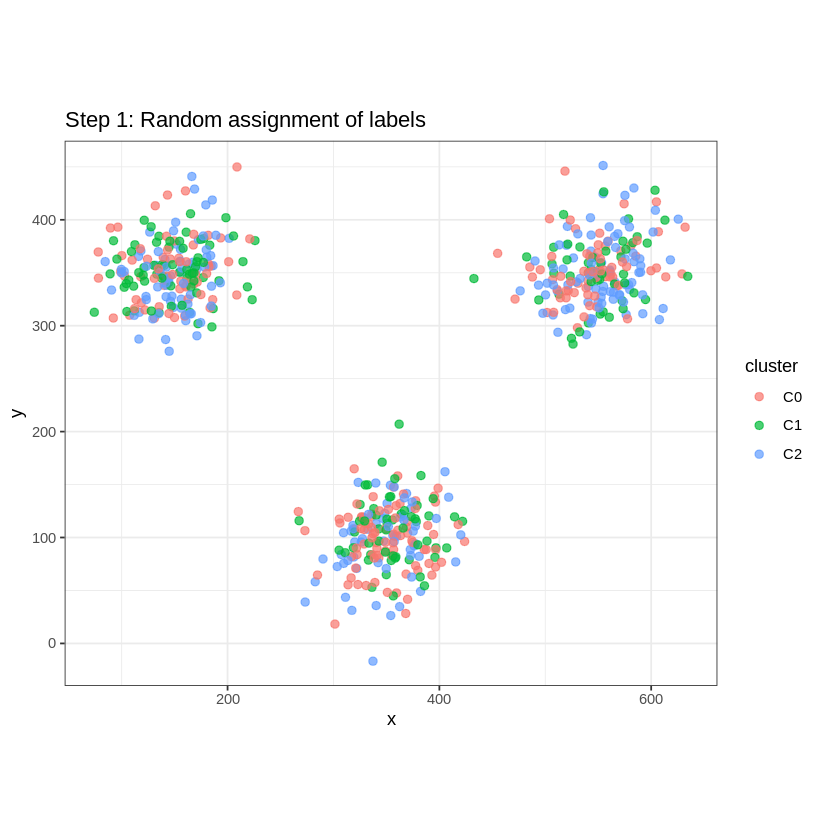

In [8]:
set.seed(123)

n <- 200

centers <- data.frame(
  cx = c(150, 350, 550),
  cy = c(350, 100, 350)
)

Sigma <- matrix(c(1000, 200,
                  200, 1000), nrow = 2)

library(MASS)

g1 <- as.data.frame(mvrnorm(n, mu = c(centers$cx[1], centers$cy[1]), Sigma))
g2 <- as.data.frame(mvrnorm(n, mu = c(centers$cx[2], centers$cy[2]), Sigma))
g3 <- as.data.frame(mvrnorm(n, mu = c(centers$cx[3], centers$cy[3]), Sigma))

df <- rbind(g1, g2, g3)
names(df) <- c("x", "y")

ggplot(df, aes(x, y)) +
  geom_point(size = 2, alpha = 0.7) +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 0: Load points")

df$cluster <- sample(c("C0", "C1", "C2"), nrow(df), replace = TRUE)

library(ggplot2)
ggplot(df, aes(x, y, color = cluster)) +
  geom_point(size = 2, alpha = 0.7) +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 1: Random assignment of labels")

#### c)

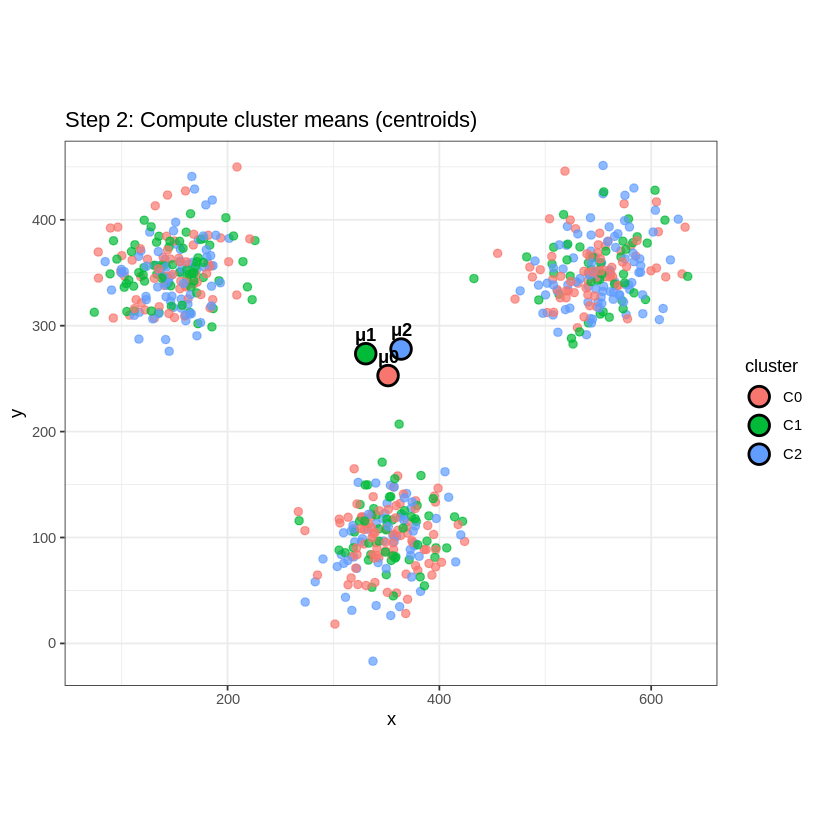

In [9]:
# compute centroids
centers_df <- df %>%
  group_by(cluster) %>%
  summarise(
    x = mean(x),
    y = mean(y),
    .groups = "drop"
  ) %>%
  arrange(cluster) %>%
  mutate(label = paste0("μ", row_number() - 1))

# plot with centroids
ggplot(df, aes(x, y, color = cluster)) +
  geom_point(size = 2, alpha = 0.7) +
  geom_point(data = centers_df, aes(x, y, fill = cluster),
             shape = 21, size = 5, color = "black", stroke = 1.2) +
  geom_text(data = centers_df, aes(x, y, label = label),
            vjust = -1, fontface = "bold", color = "black") +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 2: Compute cluster means (centroids)")

#### d)  

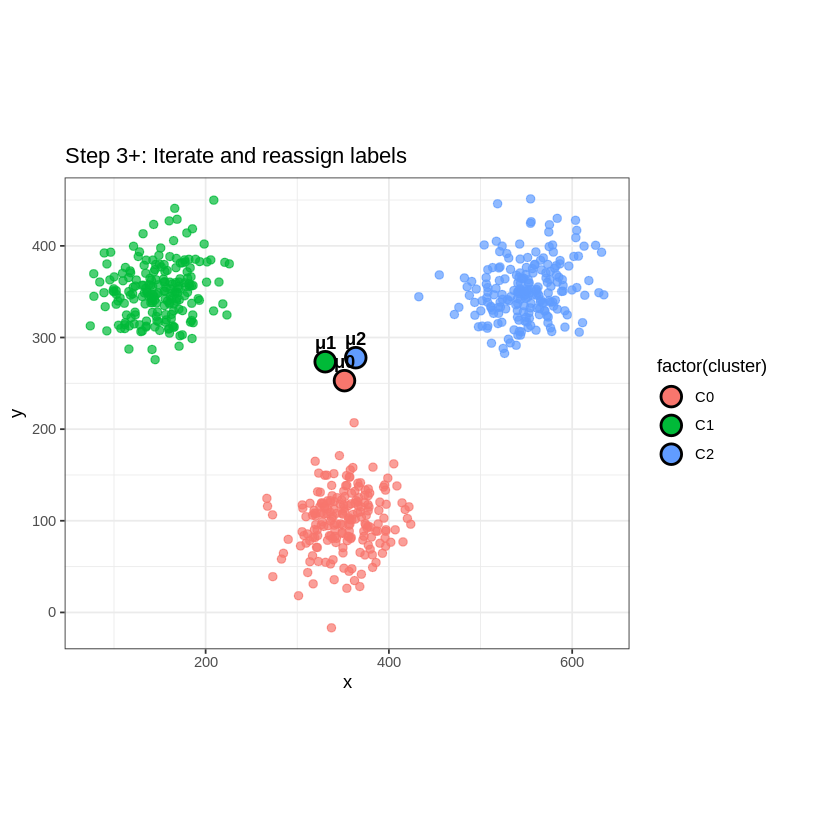

In [10]:
# function to assign each point to the nearest original centroid
assign_to_nearest <- function(df_points, centers) {
  df_points %>%
    rowwise() %>%
    mutate(
      cluster = centers$cluster[which.min(sqrt((x - centers$x)^2 + (y - centers$y)^2))]
    ) %>%
    ungroup()
}

# reassign clusters based on original centroids
df_new <- assign_to_nearest(df, centers_df)

# plot points with new clusters but original centroids
ggplot(df_new, aes(x, y, color = factor(cluster))) +
  geom_point(size = 2, alpha = 0.7) +
  geom_point(data = centers_df, aes(x, y, fill = factor(cluster)),
             shape = 21, size = 5, color = "black", stroke = 1.2) +
  geom_text(data = centers_df, aes(x, y, label = label),
            vjust = -1, fontface = "bold", color = "black") +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 3+: Iterate and reassign labels")

#### e)

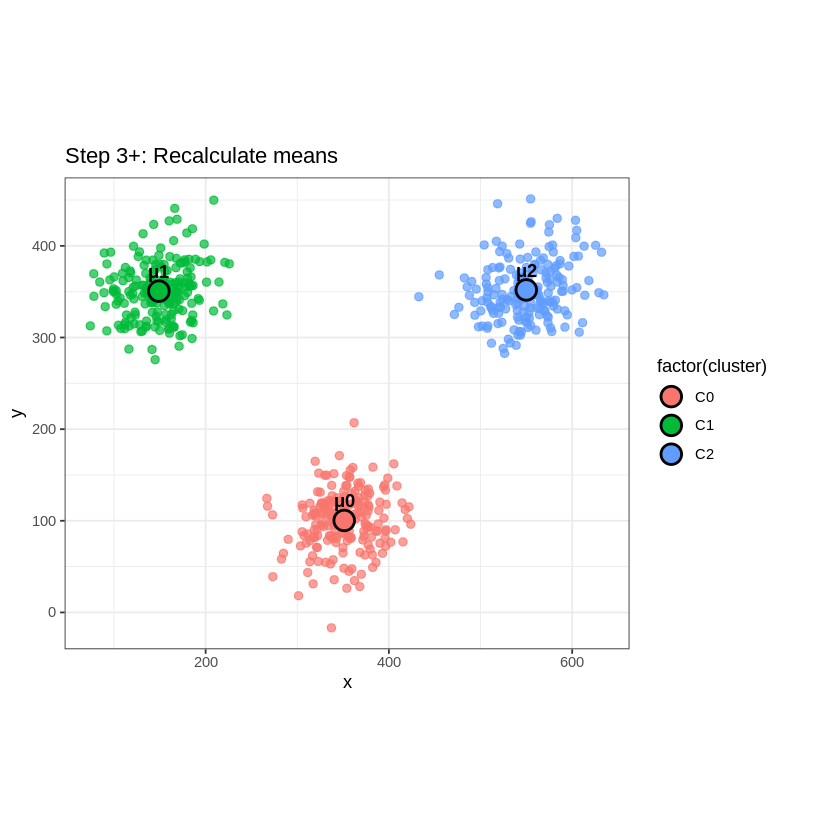

In [11]:
# compute new centroids based on reassigned clusters
new_centers_df <- df_new %>%
  group_by(cluster) %>%
  summarise(
    x = mean(x),
    y = mean(y),
    .groups = "drop"
  ) %>%
  arrange(cluster) %>%
  mutate(label = paste0("μ", row_number() - 1))

# plot updated clusters
ggplot(df_new, aes(x, y, color = factor(cluster))) +
  geom_point(size = 2, alpha = 0.7) +
  geom_point(data = new_centers_df, aes(x, y, fill = factor(cluster)),
             shape = 21, size = 5, color = "black", stroke = 1.2) +
  geom_text(data = new_centers_df, aes(x, y, label = label),
            vjust = -1, fontface = "bold", color = "black") +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 3+: Recalculate means")


#### f)

In [22]:
kmeans_custom <- function(df, k = 3, max_iter = 100, tol = 1e-6, seed = NULL) {
  if (!is.null(seed)) set.seed(seed)


  data_cols <- names(df)[1:2]
  df_cluster <- df[, data_cols]
  names(df_cluster) <- c("x", "y")

  # Step 1: Random assignment of labels
  df_cluster$cluster <- sample(paste0("C", 0:(k - 1)), nrow(df_cluster), replace = TRUE)

  for (i in 1:max_iter) {
    # Step 2: Compute cluster means (centroids) - explicitly select columns
    centers_df <- df_cluster %>%
      select(x, y, cluster) %>% # Explicitly select columns
      group_by(cluster) %>%
      summarise(
        x = mean(x),
        y = mean(y),
        .groups = "drop"
      ) %>%
      arrange(cluster)

    # Step 3: Assign each point to the nearest centroid
    df_cluster_new <- df_cluster %>%
      rowwise() %>%
      mutate(
        cluster = centers_df$cluster[which.min(sqrt((x - centers_df$x)^2 + (y - centers_df$y)^2))]
      ) %>%
      ungroup()

    # Step 4: Check for convergence
    if (all(df_cluster_new$cluster == df_cluster$cluster)) {
      break
    }

    df_cluster <- df_cluster_new
  }

  # Return results
  return(list(labels = df_cluster$cluster, means = centers_df))
}

## Question 2
This is when we'll test your `kmeans` function.
#### a) Read in the `voltages_df.csv` data set.

In [2]:
voltages_df <- read.csv("voltages_df.csv")

#### b) Call your `kmeans` function with 3 clusters. Print the results with `results$labels` and `results$means`.

In [24]:
my_results <- kmeans_custom(voltages_df, k = 3, seed = 42)

cat("\n== My K-means: results$labels (first 20) ==\n")
print(head(my_results$labels, 20))

cat("\n== My K-means: results$means ==\n")
print(my_results$means)



== My K-means: results$labels (first 20) ==
 [1] "C2" "C0" "C0" "C2" "C0" "C0" "C0" "C0" "C0" "C2" "C1" "C2" "C0" "C2" "C0"
[16] "C2" "C2" "C2" "C2" "C2"

== My K-means: results$means ==
# A tibble: 3 × 3
  cluster     x      y
  <chr>   <dbl>  <dbl>
1 C0      -1.03  1.28 
2 C1      -1.03 -0.576
3 C2      -1.03  1.11 


#### c) Call R's `kmeans` function with 3 clusters. Print the results with `results$labels` and `results$cluster`.
*Hint*: Use the `as.matrix()` function to make the `voltages_df` data frame a matrix before calling `kmeans()`.

In [26]:
cluster <- as.matrix(voltages_df)

means with 3 clusters
set.seed(42)
results <- kmeans(X, centers = 3)


cat("\n== R kmeans: results$labels (first 20) ==\n")
print(head(results$cluster, 20))

cat("\n== R kmeans: results$cluster ==\n")
print(results$cluster)

cat("\n== R kmeans: cluster centers ==\n")
print(results$centers)


== R kmeans: results$labels (first 20) ==
 [1] 2 1 1 3 3 1 2 2 3 2 2 2 2 2 1 2 2 2 2 2

== R kmeans: results$cluster ==
  [1] 2 1 1 3 3 1 2 2 3 2 2 2 2 2 1 2 2 2 2 2 1 3 1 1 3 2 2 2 2 2 2 2 1 2 2 1 1
 [38] 2 2 1 2 2 2 2 1 2 2 3 2 2 3 2 2 2 2 2 3 2 2 3 2 2 3 2 2 2 1 2 2 2 2 3 2 2
 [75] 3 3 2 2 2 2 2 2 1 2 2 3 3 3 2 2 2 2 1 2 3 3 2 3 3 2 2 2 1 2 2 2 2 2 2 1 2
[112] 2 3 2 2 2 2 2 3 3 1 3 2 2 2 1 3 2 2 2 3 2 3 2 2 1 3 3 2 2 2 3 3 2 2 2 3 2
[149] 2 2 2 2 3 3 2 2 2 2 3 2 2 2 2 3 2 2 1 2 1 2 2 2 3 2 2 2 3 2 2 3 2 1 2 2 2
[186] 3 1 2 1 2 2 3 2 2 2 2 2 3 2 2 2 2 2 2 1 2 3 2 3 2 1 2 2 2 2 1 2 2 3 3 1 1
[223] 3 3 3 2 2 2 2 2 3 2 2 3 3 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3 2 3 2 2 3 2 2 2 2
[260] 2 3 1 2 2 1 3 3 2 2 2 2 3 1 3 2 2 2 2 3 3 2 2 2 2 2 3 2 1 3 2 2 2 2 2 2 3
[297] 2 2 2 3 3 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 1 2 3 2 2 2 1 2 2 2 2 2 3 2 3 2 2
[334] 2 3 3 2 2 2 1 2 3 2 2 2 2 1 2 2 2 2 3 3 3 2 2 3 2 2 2 3 1 3 3 2 2 2 1 2 2
[371] 2 2 2 1 3 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 3 3 1 1 2 1 1 2 2 2 2 2 3 1 2 2

#### d) Are your labels/clusters the same? If not, why? Are your means the same?

The labels/clusters are very similar but not exactly the same. It probabliy has to deal with the way R calls for kmeans and the way my custom k-means calls the data. There's an arbitrary dffrence. The means aren't exactly the same, but they are very close.

## Question 3
#### a)

The "for loop" is used to used to continuously update cluster assignments and recalculate centroids until the algorithm no longer supports the continued iterations.
Each iteration improves the cluster quality by minimizing the distance between data points and their assigned centroids

#### b)

Vectorizing the code to assign clusters for kmeans is the fast apporach to take instead of looping. We will construct two large replicated matrices so that all point–cluster pairs can be compared at once, instead of looping through each data point to find its nearest centroid. It eliminates unnecessary loops.

#### c)

Vectorizing is more efficient than using a for loop because it lets the program do many calculations at once instead of one at a time. Both are doing the same kind of work, but vectorizing does it in one big, efficient group instead of many small, repeated steps.

## Question 4


K-means fails when clusters aren’t round, evenly sized, or clearly separated. K-means assumes you have vectorial data which is furthermore distributed into uniformly shaped Gaussian of about the same size and shape. It also assumes that an element is either in a cluster or not - so the probabilistic nature of the Gaussian is suppressed in favor of simplicity..

## Question 5


A Gausian Mixture Model (GMM) assumes that the data data is drawn from N Gaussian distributions whose individual parameters are estimated from the data. This can handle clusters of different sizes and shapes more easily.

## Question 6


Two points are more likely to be in the same cluster if they are close to one another. This is similar to the assumption when looking at multidimensional scaling, which requires only a metric on the original data. The mere existence of a metric is a much weaker condition than the existence of a vector space, and thus we can work with substantially more types of data.

## Question 7


It is a standard method and the basic idea is to compare the clustering for each value of K to a cluster of data "randomized" into the same domain as the original data. We can use it to compute the dispersion of the two clusterings and look at the difference.